In [1]:
#Import modules
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Function Normalization datasets
def LookupTable(value):
    classes = {
                'Developed':0,'Grass/Shrub':2,'Cropland':3,
                'Tree Cover':0,'Water':0,'Wetland':1,
                'Ice/Snow':0,'Barren':0,'Snow/Ice':0
    }
    mainClass = {
            '0':'Other land cover',
            '1':'Natural and Semi-natural grassland',
            '2':'Cultivated grassland',
            '3':'Crops and other related agricultural practices',
    }
    
    result = mainClass[str(classes[value])]
            
    return result

### Get data from LCMAP LULC data

In [6]:
#Source File and read file
originalData = '01_LCMAP_CU_20211117_V01_REF.parquet'
df = pd.read_parquet(originalData)
df

,plotid,x,y,image_year,dominant_landuse,secondary_landuse,dominant_landuse_notes,secondary_landuse_notes,dominant_landcover,second_landcover,change_process,change_process_notes,LCMAP
0,1,-1853280,1557720,1984,Rangeland,None,None,None,Barren,shrubs|grassForbHerb,None,None,Grass/Shrub
1,1,-1853280,1557720,1985,Rangeland,None,None,None,Barren,shrubs|grassForbHerb,Stable,None,Grass/Shrub
2,1,-1853280,1557720,1986,Rangeland,None,None,None,Barren,shrubs|grassForbHerb,Stable,None,Grass/Shrub
3,1,-1853280,1557720,1987,Rangeland,None,None,None,Barren,shrubs|grassForbHerb,Stable,None,Grass/Shrub
4,1,-1853280,1557720,1988,Rangeland,None,None,None,Barren,shrubs|grassForbHerb,Stable,None,Grass/Shrub
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874831,25000,1051560,1144560,2014,Forest,None,None,None,Trees,None,Stable,None,Tree Cover
874832,25000,1051560,1144560,2015,Forest,None,None,None,Trees,None,Stable,None,Tree Cover
874833,25000,1051560,1144560,2016,Forest,None,None,None,Trees,None,Stable,None,Tree Cover
874834,25000,1051560,1144560,2017,Forest,None,None,None,Trees,None,Stable,None,Tree Cover


In [7]:
#Verify rows with Nodata
round((df.isnull().sum()/df.shape[0])*100,2)

plotid                      0.00
x                           0.00
y                           0.00
image_year                  0.00
dominant_landuse            0.00
secondary_landuse          92.94
dominant_landuse_notes     89.11
secondary_landuse_notes    99.65
dominant_landcover          0.00
second_landcover           65.15
change_process              2.86
change_process_notes       99.43
LCMAP                       0.00
dtype: float64

In [8]:
#Verify duplicate rows
df.duplicated().sum()

0

In [9]:
#Class from dataset
df.LCMAP.unique()

array(['Grass/Shrub', 'Developed', 'Cropland', 'Tree Cover', 'Water',
       'Wetland', 'Barren', 'Snow/Ice'], dtype=object)

In [10]:
#Create columns from GPW project
lulc = df.copy()
lulc['dataset_name'] = 'LCMap-Conus'
lulc = lulc[['x','y','dataset_name','image_year','LCMAP']]
lulc.rename(columns={
    'image_year':'reference_year',
    'LCMAP':'original_lulc_class',
},inplace=True)

lulc['gpw_lulc_class'] = lulc['original_lulc_class'].apply(lambda x: LookupTable(x))
lulc['sample_weight'] = 1
lulc

,x,y,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight
0,-1853280,1557720,LCMap-Conus,1984,Grass/Shrub,Cultivated grassland,1
1,-1853280,1557720,LCMap-Conus,1985,Grass/Shrub,Cultivated grassland,1
2,-1853280,1557720,LCMap-Conus,1986,Grass/Shrub,Cultivated grassland,1
3,-1853280,1557720,LCMap-Conus,1987,Grass/Shrub,Cultivated grassland,1
4,-1853280,1557720,LCMap-Conus,1988,Grass/Shrub,Cultivated grassland,1
...,...,...,...,...,...,...,...
874831,1051560,1144560,LCMap-Conus,2014,Tree Cover,Other land cover,1
874832,1051560,1144560,LCMap-Conus,2015,Tree Cover,Other land cover,1
874833,1051560,1144560,LCMap-Conus,2016,Tree Cover,Other land cover,1
874834,1051560,1144560,LCMap-Conus,2017,Tree Cover,Other land cover,1


In [11]:
#Total rows
print('Rows:',lulc.shape[0])

Rows: 874836


<Axes: >

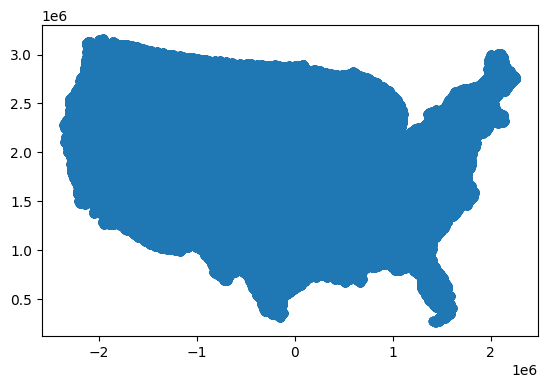

In [14]:
#Create GeoDataframe
template = gpd.read_file('auxiliary/LCMAP_CU_20200414_V01_REF.shp')
newdf = gpd.GeoDataFrame(lulc, geometry=gpd.points_from_xy(lulc.x, lulc.y),crs=template.crs)
newdf.plot()

In [15]:
#Columns information
newdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 874836 entries, 0 to 874835
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   x                    874836 non-null  int64   
 1   y                    874836 non-null  int64   
 2   dataset_name         874836 non-null  object  
 3   reference_year       874836 non-null  int64   
 4   original_lulc_class  874836 non-null  object  
 5   gpw_lulc_class       874836 non-null  object  
 6   sample_weight        874836 non-null  int64   
 7   geometry             874836 non-null  geometry
dtypes: geometry(1), int64(4), object(3)
memory usage: 53.4+ MB


In [16]:
newdf['observation'] = ''

In [17]:
newdf.iloc[:,2:]

,dataset_name,reference_year,original_lulc_class,gpw_lulc_class,sample_weight,geometry,observation
0,LCMap-Conus,1984,Grass/Shrub,Cultivated grassland,1,POINT (-1853280.000 1557720.000),
1,LCMap-Conus,1985,Grass/Shrub,Cultivated grassland,1,POINT (-1853280.000 1557720.000),
2,LCMap-Conus,1986,Grass/Shrub,Cultivated grassland,1,POINT (-1853280.000 1557720.000),
3,LCMap-Conus,1987,Grass/Shrub,Cultivated grassland,1,POINT (-1853280.000 1557720.000),
4,LCMap-Conus,1988,Grass/Shrub,Cultivated grassland,1,POINT (-1853280.000 1557720.000),
...,...,...,...,...,...,...,...
874831,LCMap-Conus,2014,Tree Cover,Other land cover,1,POINT (1051560.000 1144560.000),
874832,LCMap-Conus,2015,Tree Cover,Other land cover,1,POINT (1051560.000 1144560.000),
874833,LCMap-Conus,2016,Tree Cover,Other land cover,1,POINT (1051560.000 1144560.000),
874834,LCMap-Conus,2017,Tree Cover,Other land cover,1,POINT (1051560.000 1144560.000),


In [14]:
srcout = '01_db_lcmap-conus.parquet'
newdf.iloc[:,2:].to_parquet(srcout)